In [ ]:
!pip install transformers
!pip install conllu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 60.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 738.9/738.9 kB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.1/330.1 kB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.0/169.0 kB 27.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from collections import Counter

from transformers import BertTokenizer, BertModel, BertConfig
from transformers import AutoModelForSequenceClassification, AutoTokenizer

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn import metrics
import math
import linecache
import json
import os
import matplotlib.pyplot as plt

In [ ]:
#load the dataset, taking a certain nymber of entires per review category
json_subdir_list = os.listdir('/datasets/dylansdrive/Amazon_JSON_Repos/')
amazon_dataset = []
NUM_REVIEWS = 1000
for i in json_subdir_list:
  with open (f'/datasets/dylansdrive/Amazon_JSON_Repos/{i}/{i}', 'r') as review_extract:
    print("Loaded: ", i)
    k = 0
    # Sample from each
    while k < NUM_REVIEWS:
        temp_dict = json.loads(review_extract.readline())
        if 'reviewText' in temp_dict:
            amazon_dataset.append({'reviewText': temp_dict['reviewText'], 'overall': temp_dict['overall']})
        k += 1

Loaded:  Arts_Crafts_and_Sewing_5.json
Loaded:  Books_5.json
Loaded:  Cell_Phones_and_Accessories_5.json
Loaded:  Digital_Music_5.json
Loaded:  Automotive_5.json
Loaded:  All_Beauty_5.json
Loaded:  CDs_and_Vinyl_5.json
Loaded:  Appliances_5.json
Loaded:  Clothing_Shoes_and_Jewelry_5.json
Loaded:  Gift_Cards_5.json
Loaded:  Home_and_Kitchen_5.json
Loaded:  Video_Games_5.json
Loaded:  Luxury_Beauty_5.json
Loaded:  Industrial_and_Scientific_5.json
Loaded:  Grocery_and_Gourmet_Food_5.json
Loaded:  Electronics_5.json
Loaded:  Musical_Instruments_5.json
Loaded:  Movies_and_TV_5.json
Loaded:  Magazine_Subscriptions_5.json
Loaded:  AMAZON_FASHION_5.json


In [ ]:
np.random.shuffle(amazon_dataset)
review_count = len(amazon_dataset)
review_train, review_test = amazon_dataset[0: int(review_count / 2 * 0.75)], amazon_dataset[int(review_count / 2 * 0.75): int(review_count / 2)]
review_validation = amazon_dataset[int(review_count / 2):]

In [ ]:
#This is the Lighter Bert model distilbert-base-uncased
#Creates tokenizer and creates model
#tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
#model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased')

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased')

tokenizer_config.json: 100%|██████████| 28.0/28.0 [00:00<00:00, 4.14kB/s]
config.json: 100%|██████████| 483/483 [00:00<00:00, 82.0kB/s]
vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 42.9MB/s]
tokenizer.json: 100%|██████████| 466k/466k [00:00<00:00, 62.4MB/s]
model.safetensors: 100%|██████████| 268M/268M [00:01<00:00, 230MB/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#Sentiment Analysis function
#input: The Review (String)
#output: The Sentiment Analysis from 1-5 (int)
def sentimentAnalysis(reviewText):
    tokens = tokenizer.encode(reviewText, return_tensors='pt', truncation=True)
    sentiment = model(tokens)
    return int(torch.argmax(sentiment.logits))+1

In [ ]:
reviews = []
for i in range (len(amazon_dataset)):
    reviews.append(amazon_dataset[i]['reviewText'])
rating = []

for i in range (len(amazon_dataset)):
    rating.append(amazon_dataset[i]['overall'])

predicted = []
for i in range (len(amazon_dataset)):
    predicted.append(sentimentAnalysis(amazon_dataset[i]['reviewText']))

amazon_DF = pd.DataFrame({'reviewText': reviews, 'givenRating': rating, 'predictedRating': predicted})
#amazon_DF = pd.DataFrame({'reviewText': reviews, 'givenRating': rating})

In [ ]:
print(amazon_DF)

                                           reviewText  givenRating  \
0   So sorry I didn't purchase this years ago when...          5.0   
1   I'm old, and so is my computer.  Any advice th...          4.0   
2   I like this as a vent as well as something tha...          5.0   
3   This book has beautiful photos, good and under...          5.0   
4                            Love it!!  Great seller!          5.0   
5                                 No adverse comment.          5.0   
6   This is awesome to listen to, A must-have for ...          5.0   
7   This is the best novel I have read in 2 or 3 y...          5.0   
8                             It's good for beginners          5.0   
9                 Contains some interesting stitches.          4.0   
10  This game is a bit hard to get the hang of, bu...          5.0   
11  Looks even better in person. Be careful to not...          5.0   
12  This worked really well for what I used it for...          5.0   
13                  

In [ ]:
given_score = amazon_DF['givenRating']
predicted_score = amazon_DF['predictedRating']
print("Accuracy: ", accuracy_score(given_score, predicted_score))
print("Macro-precision: ", precision_score(given_score, predicted_score, average='macro'))
print("Micro-precision: ", precision_score(given_score, predicted_score, average='micro'))
print("Macro-recall: ", recall_score(given_score, predicted_score, average='macro'))
print("Micro-recall: ", recall_score(given_score, predicted_score, average='micro'))
print("sentimentAnalysis score: " + str(sentimentAnalysis(amazon_dataset[3]['reviewText'])))
print("reviewText: " + amazon_dataset[3]['reviewText'])
print("overall: " + str(amazon_dataset[3]['overall']))

predictions = [sentimentAnalysis(review_train[x]['reviewText']) for x in range(len(review_train))]
#print(predictions)

Accuracy:  0.0
Macro-precision:  0.0
Micro-precision:  0.0
Macro-recall:  0.0
Micro-recall:  0.0
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
sentimentAnalysis score: 1
reviewText: This book has beautiful photos, good and understandable directions, and many different kinds of jewelry.  Wire working and metalsmithing jewelry are covered.  Highly recommend this book.
overall: 5.0


In [ ]:
# calulate sentiment distance
# takes in iterable lists of preds and actual labels and calculates the average sentiment distance
def SD(preds, actual):
    SD_res = []
    for i in preds:
        tmp = 5 - abs(actual[i] - preds[i])
        tmp = tmp / 5
        SD_res.append(tmp)
    
    return sum(SD_res) / len(SD_res)

Sentiment distance:  0.4000000000000001


ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of ticklabels (5).

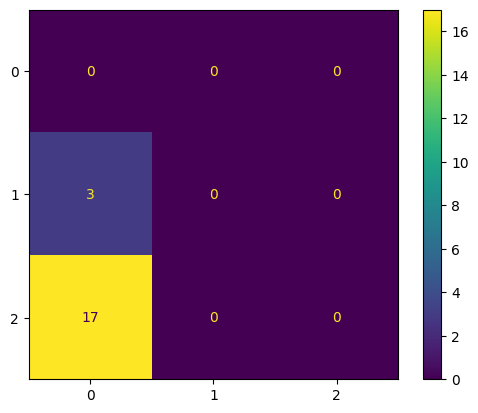

In [ ]:
#sentiment distance of basic model
print("Sentiment distance: ", SD(predicted, rating))

#confusion matrix for base model
confusion_matrix = metrics.confusion_matrix(rating, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [ '1', '2', '3', '4', '5'])
cm_display.plot()

0  of  20  completed.
Accuracy:  0.55
Macro-precision:  0.22916666666666666
Micro-precision:  0.55
Macro-recall:  0.16176470588235295
Micro-recall:  0.55
Sentiment distance:  0.64
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of ticklabels (5).

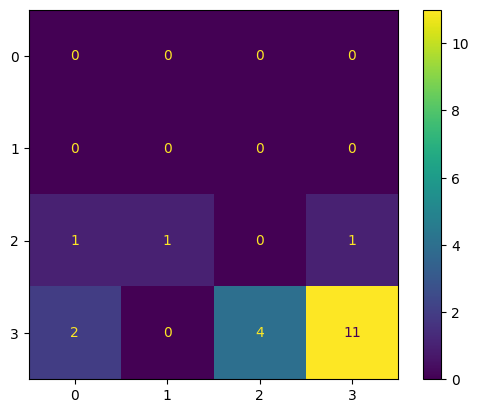

In [ ]:
#standard BERT model
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

#test the pre-trained model on the entire dataset - how accurate is it, as a baseline?
predicted = []
for i in range (len(amazon_dataset)):
    if (i % 1000 == 0):
        print(i, " of ", len(amazon_dataset), " completed.")
    predicted.append(sentimentAnalysis(amazon_dataset[i]['reviewText']))

amazon_DF = pd.DataFrame({'reviewText': reviews, 'givenRating': rating, 'predictedRating': predicted})

#scores for model 
given_score = amazon_DF['givenRating']
predicted_score = amazon_DF['predictedRating']
print("Accuracy: ", accuracy_score(given_score, predicted_score))
print("Macro-precision: ", precision_score(given_score, predicted_score, average='macro'))
print("Micro-precision: ", precision_score(given_score, predicted_score, average='micro'))
print("Macro-recall: ", recall_score(given_score, predicted_score, average='macro'))
print("Micro-recall: ", recall_score(given_score, predicted_score, average='micro'))

print("Sentiment distance: ", SD(predicted, rating))

confusion_matrix = metrics.confusion_matrix(rating, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [ '1', '2', '3', '4', '5'])
cm_display.plot()


In [ ]:
#test the model with relative key query embedding
predicted = []
for i in range (len(amazon_dataset)):
    if (i % 1000 == 0):
        print(i, " of ", len(amazon_dataset), " completed.")
    predicted.append(sentimentAnalysis(amazon_dataset[i]['reviewText']))

amazon_DF = pd.DataFrame({'reviewText': reviews, 'givenRating': rating, 'predictedRating': predicted})

#scores for model with relative key query embedding
given_score = amazon_DF['givenRating']
predicted_score = amazon_DF['predictedRating']
print("Accuracy: ", accuracy_score(given_score, predicted_score))
print("Macro-precision: ", precision_score(given_score, predicted_score, average='macro'))
print("Micro-precision: ", precision_score(given_score, predicted_score, average='micro'))
print("Macro-recall: ", recall_score(given_score, predicted_score, average='macro'))
print("Micro-recall: ", recall_score(given_score, predicted_score, average='micro'))

print("Sentiment distance: ", SD(predicted, rating))

confusion_matrix = metrics.confusion_matrix(rating, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [ '1', '2', '3', '4', '5'])
cm_display.plot()

In [ ]:
#test affect of position embedding algorithm differences
config = BertConfig.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment', position_embedding_type = 'relative_key')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment', config = config)

#test the model with relative key query embedding
predicted = []
for i in range (len(amazon_dataset)):
    if (i % 1000 == 0):
        print(i, " of ", len(amazon_dataset), " completed.")
    predicted.append(sentimentAnalysis(amazon_dataset[i]['reviewText']))

amazon_DF = pd.DataFrame({'reviewText': reviews, 'givenRating': rating, 'predictedRating': predicted})

#scores for model with relative key query embedding
given_score = amazon_DF['givenRating']
predicted_score = amazon_DF['predictedRating']
print("Accuracy: ", accuracy_score(given_score, predicted_score))
print("Macro-precision: ", precision_score(given_score, predicted_score, average='macro'))
print("Micro-precision: ", precision_score(given_score, predicted_score, average='micro'))
print("Macro-recall: ", recall_score(given_score, predicted_score, average='macro'))
print("Micro-recall: ", recall_score(given_score, predicted_score, average='micro'))

print("Sentiment distance: ", SD(predicted, rating))

confusion_matrix = metrics.confusion_matrix(rating, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [ '1', '2', '3', '4', '5'])
cm_display.plot()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0b63f49d-657e-40c3-abbf-efbd6029b8d0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>